In [116]:
import pickle
from scipy import signal
from scipy.io import wavfile
import numpy as np
from IPython.display import display, Audio
import tensorflow as tf
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms as T
from torch.utils.data import Dataset, TensorDataset, DataLoader
from tqdm.auto import tqdm
from sklearn.metrics import r2_score
from IPython.display import clear_output
from ipywidgets import interact
from PIL import Image
from sklearn.decomposition import PCA
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.pyplot as plt
%matplotlib inline

In [117]:
!ffmpeg -y -i good_morning.mp4 -ac 1 -ar 16000 audio.wav
!ffmpeg -y -i noise_samples/waterfall.mp3 -ac 1 -ar 16000 noise.wav

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

In [118]:
# считывание аудио файла
fs, data = wavfile.read('audio.wav')
data = data / (2**16-1)
data[0] = 1
# добавление шума
#noise = np.random.normal(scale=0.25*data.std(), size=data.shape)
_, noise = wavfile.read('noise.wav')
noise = noise / (2**16-1) 
noise = np.tile(noise, 1+data.size//noise.size)[:data.size].copy()
noise = (0.1*data.max()/noise.max())*noise
data_noised = data+noise#np.clip(data + noise, -1, 1)

In [119]:
print('Original')
display(Audio(data[fs*10:fs*25], rate=fs))
print('Noised')
display(Audio(data_noised[fs*10:fs*25], rate=fs))

Original


Noised


In [120]:
_, _, Zxx = signal.stft(data_noised, fs=fs, nperseg=512)
_, xrec = signal.istft(Zxx, fs)
print('Reconstructed Noised')
display(Audio(xrec[fs*10:fs*25], rate=fs))
_, _, Zxx0 = signal.stft(noise, fs=fs, nperseg=512)
_, xrec = signal.istft(Zxx0, fs)
print('Noise')
display(Audio(xrec[fs*10:fs*25], rate=fs))

Reconstructed Noised


Noise


In [121]:
# https://github.com/digantamisra98/Mish
class Mish(nn.Module):
    def __init__(self):
        super().__init__()
        self.softplus = nn.Softplus()
        self.tanh = nn.Tanh()
    
    def forward(self, x):
        return x*self.tanh(self.softplus(x))

class DenoisingAE(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv1d(2, 256, kernel_size=3, stride=2, padding=1),
            Mish(),
            nn.Conv1d(256, 512, kernel_size=3, stride=2, padding=1),
            Mish(),
            nn.Conv1d(512, 800, kernel_size=3, stride=2, padding=1),
            Mish(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(800, 512, kernel_size=3, stride=2, padding=1),
            Mish(),
            nn.ConvTranspose1d(512, 256, kernel_size=3, stride=2, padding=1),
            Mish(),
            nn.ConvTranspose1d(256, 2, kernel_size=3, stride=2, padding=1),
        )
            

    def forward(self, x):
        encoded = self.encoder(x)
        return self.decoder(encoded)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = DenoisingAE()
net.to(device)
print(Zxx.shape[0])
net(torch.rand(1, 2, Zxx.shape[0], device=device)).detach().cpu().numpy().shape

257


(1, 2, 257)

In [122]:
criterion = nn.MSELoss()#nn.SmoothL1Loss()
optimizer = optim.Adam(net.parameters(), lr=1e-4)#, weight_decay=1e-6)

In [123]:
batch_size = 128

X = np.concatenate([np.real(Zxx).T[:,:,None],
                    np.imag(Zxx).T[:,:,None]], axis=-1)
y = np.concatenate([np.real(Zxx0).T[:,:,None],
                    np.imag(Zxx0).T[:,:,None]], axis=-1)

normalization = X.reshape(-1, 2).std()
X /= normalization
y /= normalization
tensor_x = torch.Tensor(np.transpose(X, [0, 2, 1])) # channels first
tensor_y = torch.Tensor(np.transpose(y, [0, 2, 1])) # channels first

train_dataset = TensorDataset(tensor_x[:tensor_x.shape[0]*9//10],
                              tensor_y[:tensor_x.shape[0]*9//10]) # create your datset
train_dataloader = DataLoader(train_dataset,
                              batch_size=batch_size, shuffle=True) # create your dataloader
test_dataset = TensorDataset(tensor_x[tensor_x.shape[0]*9//10:],
                              tensor_y[tensor_x.shape[0]*9//10:]) # create your datset
test_dataloader = DataLoader(test_dataset,
                             batch_size=batch_size, shuffle=True) # create your dataloader

In [124]:
def eval_dataset(dataloader):
    net.eval()
    target = []
    pred = []
    for i, data in enumerate(dataloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        preds = net(inputs).detach().cpu().numpy()
        target.append(inputs.detach().cpu().numpy().reshape(inputs.shape[0], -1))
        pred.append(preds.reshape(inputs.shape[0], -1))
    net.train()
    target = np.concatenate(target)
    pred = np.concatenate(pred)
    return r2_score(target, pred)

eval_dataset(train_dataloader)

-2.828770576642327

  0%|          | 0/15 [00:00<?, ?it/s]

0it [00:00, ?it/s]

[1,    83] loss: 0.10863
R2 score on train: 0.45879547150292327
R2 score on val: 0.46236015353298154


0it [00:00, ?it/s]

[2,    83] loss: 0.07832
R2 score on train: 0.5681464815480652
R2 score on val: 0.5807524722871318


0it [00:00, ?it/s]

[3,    83] loss: 0.07341
R2 score on train: 0.5871661700683122
R2 score on val: 0.6037273551371239


0it [00:00, ?it/s]

[4,    83] loss: 0.07121
R2 score on train: 0.6043779107415913
R2 score on val: 0.6232593141793726


0it [00:00, ?it/s]

[5,    83] loss: 0.06958
R2 score on train: 0.6236766584221367
R2 score on val: 0.6441093230161071


0it [00:00, ?it/s]

[6,    83] loss: 0.06815
R2 score on train: 0.595832319366579
R2 score on val: 0.6112392440493928


0it [00:00, ?it/s]

[7,    83] loss: 0.06761
R2 score on train: 0.6361810008135957
R2 score on val: 0.6604100256416161


0it [00:00, ?it/s]

[8,    83] loss: 0.06678
R2 score on train: 0.6290464620619984
R2 score on val: 0.6554666042343683


0it [00:00, ?it/s]

[9,    83] loss: 0.06608
R2 score on train: 0.6338552007496152
R2 score on val: 0.6607515586924165


0it [00:00, ?it/s]

[10,    83] loss: 0.06525
R2 score on train: 0.6269464100218651
R2 score on val: 0.6541928753754523


0it [00:00, ?it/s]

[11,    83] loss: 0.06466
R2 score on train: 0.6258875756249459
R2 score on val: 0.653374874480065


0it [00:00, ?it/s]

[12,    83] loss: 0.06434
R2 score on train: 0.6250690988961999
R2 score on val: 0.6545079117917569


0it [00:00, ?it/s]

[13,    83] loss: 0.06372
R2 score on train: 0.6428033369199017
R2 score on val: 0.6726477372037407


0it [00:00, ?it/s]

[14,    83] loss: 0.06302
R2 score on train: 0.6442434387276892
R2 score on val: 0.6748926590573479


0it [00:00, ?it/s]

[15,    83] loss: 0.06250
R2 score on train: 0.6294605683292591
R2 score on val: 0.6587051431009239
Finished Training


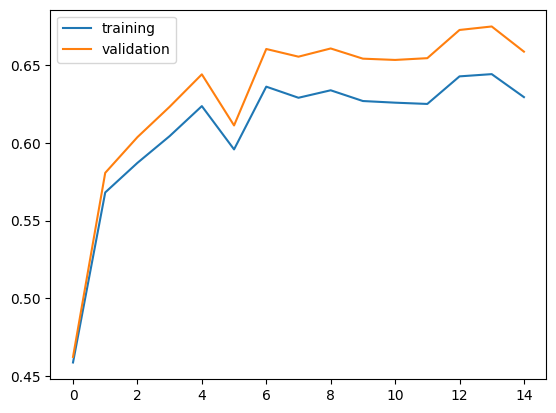

In [125]:
scores = []
scores_val = []
net.train()
for epoch in tqdm(range(15)):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, batch in tqdm(enumerate(train_dataloader, 0)):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
    print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / len(train_dataloader):.5f}')
    scores.append(eval_dataset(train_dataloader))
    scores_val.append(eval_dataset(test_dataloader))
    print('R2 score on train:', scores[-1])
    print('R2 score on val:', scores_val[-1])
print('Finished Training')
plt.plot(scores, label='training')
plt.plot(scores_val, label='validation')
plt.legend()

In [126]:
net.eval()
pred = []
batch_size = 128
for i in tqdm(range(tensor_x.shape[0]//batch_size+1)):
    preds = net(tensor_x[i*batch_size:(i+1)*batch_size].to(device))
    pred.append(np.transpose(preds.detach().cpu().numpy(),
                             [0, 2, 1])*normalization)
pred = np.concatenate(pred, axis=0) 
_, xrec = signal.istft((pred[:,:,0]+pred[:,:,1]*1j).T, fs)
xrec = data_noised - xrec[:data.size]
print(r2_score(data, data_noised))
print(r2_score(data, xrec[:data.size]))
print('Original')
display(Audio(data[fs*10:fs*25], rate=fs))
print('Noised')
display(Audio(data_noised[fs*10:fs*25], rate=fs))
print('Denoised')
display(Audio(xrec[fs*10:fs*25], rate=fs))

  0%|          | 0/92 [00:00<?, ?it/s]

0.8106756188360859
0.9284557798403392
Original


Noised


Denoised
